# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Data loading and preprocessing
Remember to change the path if needed be

### Hyperparameters of preprocessing

In [102]:
m = 2000; M = 12000; 
bin_size = 5;

path = "D:/GitHub/Machine-Learning/Kaggle/"
# path = "C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/"

# # Take the data from Google Drive
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# path = "/content/drive/My Drive/Colab Notebooks/Kaggle/"

In [3]:
savepath = path + 'Kaggle classifiers/bin size 5/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;

In [4]:
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

In [5]:
def spectrum_in_bins(df,m,M,bin_size):
    # Now, let's define the mz ranges, and the label associated to each of them (the mean of the limiting values of each bin)
    range_min = []; range_max = []; range_label = [];
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_label.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum
                idx_data_in_bins[0,i] = 0   

        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_label, index = df.index)
    return new_df

In [6]:
df_train = df_train.drop_duplicates(subset='ID_sample') # eliminate duplicates
# Let's work without duplicates from now on, to avoid having same sample in training and test_training sets

# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.3, random_state=0) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = spectrum_in_bins(data_train,m,M,bin_size)
spectrum_test_train = spectrum_in_bins(data_test_train,m,M,bin_size)
print('Spectrum regularized!')
# these spectrum_... are our X for training

Training samples: 179 and test_train samples: 78
Spectrum regularized!


In [7]:
def clean_nan_samples(spectrum,targets, c, cat):
# if there are any NaN values, we should remove those samples
    if (targets[cat].isnull().sum() > 0).all(): 
        merged = pd.concat([spectrum , targets],axis=1,copy=True)
        clean = merged.dropna(subset=[cat])
        print('Dropped ',len(merged)-len(clean))
        Y = clean.iloc[:,-9+c].to_numpy().reshape(-1,)
        X = clean.iloc[:,:-9]

    else:
        Y = targets.iloc[:,c].to_numpy().reshape(-1,)
        X = spectrum.copy(deep=True)
    return X , Y

# Try different classifiers
The try_clf function has been built for, given a classifier and a parameter dictionary (for hyperparameter cross-validation), create a classifier for each antibiotic, and return the results. This enables for fast testing of different classifiers. Moreover, the function also takes charge of suppressing NaN values in the targets ocurring for amikacina, levofloxacino and tobramicina.

In [8]:
def try_clf(clf,params,n_cv=5):  # new version! (after Sevilla)
    t1 = time.time()
    
    best_classifiers = [];
    grid_list = [];
    AUC_train = []; AUC_test_train = [];
    
    categories = targets_train.columns[:]    
    for c,cat in enumerate(categories):

        print([cat]) # indicate in which antibiotic we are
        
        # Selection of train and test data (depending on whether there are NaN target values)
        X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
        X_test_train, Y_test_train = clean_nan_samples(spectrum_test_train,targets_test_train, c, cat)
            
        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(clf,param_grid=params,scoring='roc_auc',n_jobs=njobs,pre_dispatch='2*n_jobs', cv=n_cv, iid=False,return_train_score=True)
        grid.fit(X_train, Y_train)

        # print the best parameters (to detect edge values), and save that classifier
        print('The best parameters are: ',grid.best_params_)
        best_clf = grid.best_estimator_
        best_classifiers.append(best_clf)
        grid_list.append(grid)
        
        # compute the AUC of the classifier
        if callable(getattr(best_clf,"predict_proba",None)):
            pred_train = best_clf.predict_proba(X_train)[:,-1] # only take last column, the prob of Y = +1
            pred_test = best_clf.predict_proba(X_test_train)[:,-1]
        else:
            print('Using decision_function instead of predict_proba')
            pred_train = best_clf.decision_function(X_train)
            pred_test = best_clf.decision_function(X_test_train)            
        auc_score_train = roc_auc_score(Y_train, pred_train)
        auc_score_test = roc_auc_score(Y_test_train, pred_test)
        print('Train AUC: ',np.round(auc_score_train,4),' and test_train AUC: ',np.round(auc_score_test,4))
        AUC_train.append(auc_score_train)
        AUC_test_train.append(auc_score_test)
        
    avg_AUC_train = np.mean(AUC_train)
    avg_AUC_test_train = np.mean(AUC_test_train)
    print('\n\nThe average train AUC is',np.round(avg_AUC_train,4),'and the avg test_train AUC is',np.round(avg_AUC_test_train,4))
    
    t2 = time.time()
    print('\nFull execution took ',np.round(t2-t1,1),'seconds')
    print('\nDONE!')
    return best_classifiers, grid_list, AUC_train, AUC_test_train

## Also enable L1 feature selection

In [96]:
def get_l1_clfs():
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(penalty='l1',solver='liblinear',max_iter=1e6, class_weight='balanced')
    params = {'C':10.**np.arange(0,3)} # only up to 100, so that enough little features remain
    l1_best_clfs,_,_,_ = try_clf(clf,params)
    return l1_best_clfs

def obtain_l1_vects(l1_best_clfs,spectrum_train,targets_train):
    l1_feat_list = []    
    categories = targets_train.columns[:]
    
    for c, cat in enumerate(categories):
        n = np.sum(np.abs(l1_best_clfs[c].coef_) > 0)
        print('Number of features:',n)
        while n == 0:
            clf = l1_best_clfs[c]
            c_value = clf.get_params()['C']
            new_c = c_value * 10
            clf.set_params(C=new_c)
            X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)            
            clf.fit(X_train, Y_train) # refit with higher C
            l1_best_clfs[c] = clf
            n = np.sum(np.abs(clf.coef_) > 0)
            print(n)
    
        # once we know we have at least one non-zero feature
        vect = (np.abs(l1_best_clfs[c].coef_)>0).reshape(-1,)
        l1_feat_list.append(vect)
    return l1_feat_list

# to be applyied to each category
def apply_l1_feature_selection(spectrum_train,vect): # vect is l1_feat_list[c]
    new_spectrum = spectrum_train.copy(deep=True).iloc[:,vect]   
    return new_spectrum

In [10]:
def try_clf_feat_selection(clf, params, feature_vector_list, n_cv=5):  # after Sevilla
    t1 = time.time()
    
    best_classifiers = [];
    grid_list = [];
    AUC_train = []; AUC_test_train = [];
    
    categories = targets_train.columns[:]    
    for c,cat in enumerate(categories):

        print([cat]) # indicate in which antibiotic we are
        
        # Selection of train and test data (depending on whether there are NaN target values)
        X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
        X_test_train, Y_test_train = clean_nan_samples(spectrum_test_train,targets_test_train, c, cat)
        
        X_train = apply_l1_feature_selection(X_train,feature_vector_list[c])
        X_test_train = apply_l1_feature_selection(X_test_train,feature_vector_list[c])
            
        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(clf,param_grid=params,scoring='roc_auc',n_jobs=njobs,pre_dispatch='2*n_jobs', cv=n_cv, iid=False,return_train_score=True)
        grid.fit(X_train, Y_train)

        # print the best parameters (to detect edge values), and save that classifier
        print('The best parameters are: ',grid.best_params_)
        best_clf = grid.best_estimator_
        best_classifiers.append(best_clf)
        grid_list.append(grid)
        
       # compute the AUC of the classifier
        if callable(getattr(best_clf,"predict_proba",None)):
            pred_train = best_clf.predict_proba(X_train)[:,-1] # only take last column, the prob of Y = +1
            pred_test = best_clf.predict_proba(X_test_train)[:,-1]
        else:
            print('Using decision_function instead of predict_proba')
            pred_train = best_clf.decision_function(X_train)
            pred_test = best_clf.decision_function(X_test_train)            
        auc_score_train = roc_auc_score(Y_train, pred_train)
        auc_score_test = roc_auc_score(Y_test_train, pred_test)
        print('Train AUC: ',np.round(auc_score_train,4),' and test_train AUC: ',np.round(auc_score_test,4))
        AUC_train.append(auc_score_train)
        AUC_test_train.append(auc_score_test)
        
    avg_AUC_train = np.mean(AUC_train)
    avg_AUC_test_train = np.mean(AUC_test_train)
    print('\n\nThe average train AUC is',np.round(avg_AUC_train,4),'and the avg test_train AUC is',np.round(avg_AUC_test_train,4))
    
    t2 = time.time()
    print('\nFull execution took ',np.round(t2-t1,1),'seconds')
    print('\nDONE!')
    return best_classifiers, grid_list, AUC_train, AUC_test_train

In [11]:
with open(savepath+'l1_best_clfs_nodup.data', 'rb') as filehandle:
    l1_best_clfs = pickle.load(filehandle)
with open(savepath+'l1_feat_list_nodup.data', 'rb') as filehandle:
    l1_feat_list = pickle.load(filehandle)

## save_clf  &  load_clf
Let's implement these functions so that we can load previous results without need to perform try_clf on all executions of the notebook.

In [12]:
def save_clf(savepath,filename,clf_list):
  # filename must be without extension
  if (savepath[-1] != '/'): savepath = savepath + '/'
  with open(savepath+filename+'.data','wb') as filehandle:
    pickle.dump(clf_list,filehandle)

def load_clf(savepath,filename):
  if (savepath[-1] != '/'): savepath = savepath + '/'
  if os.path.isfile(savepath+filename+'.data'):
    with open(savepath+filename+'.data','rb') as filehandle:
      new_list = pickle.load(filehandle)
    print('Loaded!')
  else:
    print('File not found')
    new_list = []
  return new_list

## SVM - RBF - fixed gamma

In [13]:
clf = SVC(kernel='rbf', class_weight='balanced', gamma=0.1) # let's first try with fixed gamma
params = {'C':2.**np.arange(-10,20)}
linear_SVM_best_clfs, grid_list, AUC_train, AUC_test_train = try_clf_feat_selection(clf, params, l1_feat_list, n_cv=5)
# save_clf(savepath,'linear_SVM',linear_SVM_best_clfs)

['OXACILINA']
The best parameters are:  {'C': 32.0}
Using decision_function instead of predict_proba
Train AUC:  0.9364  and test_train AUC:  0.8607
['AMIKACINA']
Dropped  35
Dropped  11
The best parameters are:  {'C': 512.0}
Using decision_function instead of predict_proba
Train AUC:  0.9978  and test_train AUC:  0.7676
['AMOXI/CLAV']
The best parameters are:  {'C': 256.0}
Using decision_function instead of predict_proba
Train AUC:  0.9744  and test_train AUC:  0.8349
['CIPROFLOXACINO']
The best parameters are:  {'C': 256.0}
Using decision_function instead of predict_proba
Train AUC:  0.9896  and test_train AUC:  0.8729
['CLINDAMICINA']
The best parameters are:  {'C': 0.5}
Using decision_function instead of predict_proba
Train AUC:  0.704  and test_train AUC:  0.5167
['ERITROMICINA']
The best parameters are:  {'C': 128.0}
Using decision_function instead of predict_proba
Train AUC:  0.9803  and test_train AUC:  0.6545
['LEVOFLOXACINO']
Dropped  2
The best parameters are:  {'C': 32.0}
U

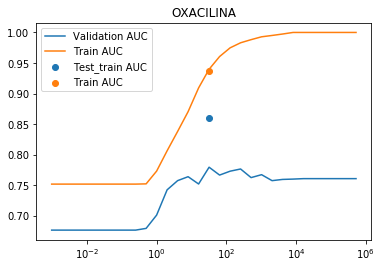

Train AUC:  0.9364  and test_train AUC:  0.8607


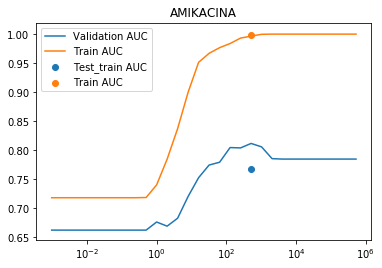

Train AUC:  0.9978  and test_train AUC:  0.7676


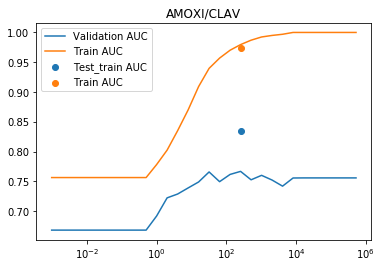

Train AUC:  0.9744  and test_train AUC:  0.8349


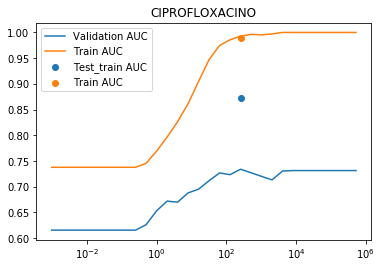

Train AUC:  0.9896  and test_train AUC:  0.8729


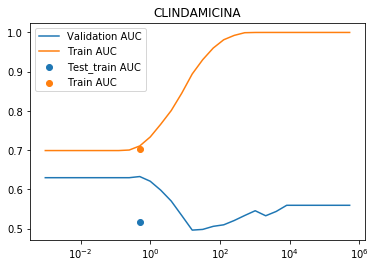

Train AUC:  0.704  and test_train AUC:  0.5167


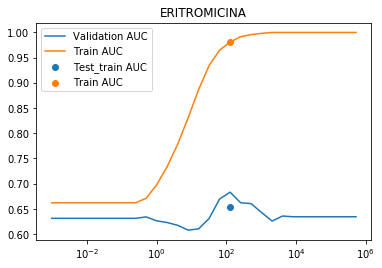

Train AUC:  0.9803  and test_train AUC:  0.6545


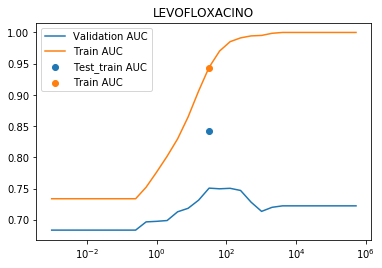

Train AUC:  0.9423  and test_train AUC:  0.8417


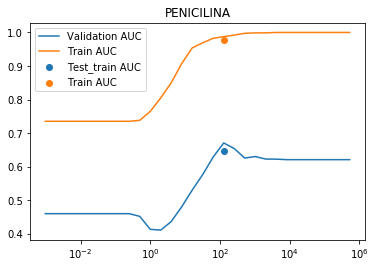

Train AUC:  0.9778  and test_train AUC:  0.6471


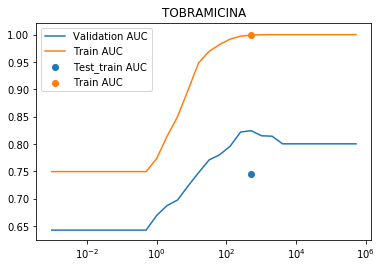

Train AUC:  0.9986  and test_train AUC:  0.746


In [17]:
categories = targets_train.columns[:]  
m = [] # to store mean validation errors
for idx in np.arange(len(grid_list)):
    g = grid_list[idx].cv_results_

    m.append(g['mean_test_score'])
    plt.semilogx(g['param_C'].data,g['mean_test_score'],label='Validation AUC')
    plt.semilogx(g['param_C'].data,g['mean_train_score'],label='Train AUC')
    plt.scatter(linear_SVM_best_clfs[idx].C, AUC_test_train[idx],label='Test_train AUC')
    plt.scatter(linear_SVM_best_clfs[idx].C, AUC_train[idx],label='Train AUC')
    plt.legend()
    plt.title(categories[idx])
    plt.show()
    
    
    print('Train AUC: ',np.round(AUC_train[idx],4),' and test_train AUC: ',np.round(AUC_test_train[idx],4))

What we can clearly see here is that in many cases our test_train AUC is overestimating the capacity of our estimators. Therefore, it makes more sense to redefine the function so that the mean test score is displayed, instead of the AUC of a test_train set in which results may vary depending on the split.

This also mean to eliminate test_train split, and use only train and validation scores. Test will be the Kaggle submission.

In [25]:
df_train = df_train.drop_duplicates(subset='ID_sample') # eliminate duplicates
# Let's work without duplicates from now on, to avoid having same sample in training and test_training sets

# Extract data (spectra) and targets of the df_train set
data_train = df_train.iloc[:,-2:]
targets_train = df_train.iloc[:,1:-2]

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = spectrum_in_bins(data_train,m,M,bin_size)
print('Spectrum regularized!')
# these spectrum_... are our X for training

Spectrum regularized!


In [56]:
def try_clf(clf,params,n_cv=5,L1_FEATURE_SELECTION=False, feature_vector_list=None):  # new version! (after Sevilla)
    # new version --> Incorporates feature selection
    t1 = time.time()
    
    best_classifiers = [];
    grid_list = [];
    AUC_train = []; AUC_valid = [];
    
    categories = targets_train.columns[:]    
    for c,cat in enumerate(categories):

        print([cat]) # indicate in which antibiotic we are
        
        # Selection of train and test data (depending on whether there are NaN target values)
        X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
        
        if L1_FEATURE_SELECTION: # a boolean that decides whether to apply L1 feature selection (L1 feature list has to be already defined, and input to the function)
            X_train = apply_l1_feature_selection(X_train,feature_vector_list[c])
            
        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(clf,param_grid=params,scoring='roc_auc',n_jobs=njobs,pre_dispatch='2*n_jobs', cv=n_cv, iid=False,return_train_score=True)
        grid.fit(X_train, Y_train)

        # print the best parameters (to detect edge values), and save that classifier
        print('The best parameters are: ',grid.best_params_)
        best_clf = grid.best_estimator_
        best_classifiers.append(best_clf)
        grid_list.append(grid)
        
        best_clf = np.where(grid.cv_results_['rank_test_score']==1)[0][0]
        AUC_train.append(grid.cv_results_['mean_train_score'][best_clf])
        AUC_valid.append(grid.cv_results_['mean_test_score'][best_clf])
        
        print('Train AUC: ',np.round(AUC_train[-1],4),' and validation AUC: ',np.round(AUC_valid[-1],4))
        
    avg_AUC_train = np.mean(AUC_train)
    avg_AUC_valid = np.mean(AUC_valid)
    print('\n\nThe average train AUC is',np.round(avg_AUC_train,4),'and the avg validation AUC is',np.round(avg_AUC_valid,4))
    
    t2 = time.time()
    print('\nFull execution took ',np.round(t2-t1,1),'seconds')
    print('\nDONE!')
    return best_classifiers, grid_list, AUC_train, AUC_valid

In [59]:
# let's redo it and check if we get the same results
clf = SVC(kernel='rbf', class_weight='balanced', gamma=0.1)
linear_SVM_best_clfs, grid_list, AUC_train, AUC_valid = try_clf(clf, params, 5, True, l1_feat_list)

['OXACILINA']
The best parameters are:  {'C': 128.0}
Train AUC:  0.966  and validation AUC:  0.8034
['AMIKACINA']
Dropped  46
The best parameters are:  {'C': 16384.0}
Train AUC:  1.0  and validation AUC:  0.7724
['AMOXI/CLAV']
The best parameters are:  {'C': 512.0}
Train AUC:  0.9822  and validation AUC:  0.7994
['CIPROFLOXACINO']
The best parameters are:  {'C': 64.0}
Train AUC:  0.9679  and validation AUC:  0.7756
['CLINDAMICINA']
The best parameters are:  {'C': 16384.0}
Train AUC:  1.0  and validation AUC:  0.6308
['ERITROMICINA']
The best parameters are:  {'C': 512.0}
Train AUC:  0.9942  and validation AUC:  0.6747
['LEVOFLOXACINO']
Dropped  2
The best parameters are:  {'C': 32.0}
Train AUC:  0.9485  and validation AUC:  0.7628
['PENICILINA']
The best parameters are:  {'C': 16384.0}
Train AUC:  1.0  and validation AUC:  0.6807
['TOBRAMICINA']
Dropped  43
The best parameters are:  {'C': 16384.0}
Train AUC:  1.0  and validation AUC:  0.7539


The average train AUC is 0.9843 and the av

In [67]:
def plot_valid_vs_train(grid_list,AUC_train,AUC_valid,parameter_str):
    categories = targets_train.columns[:]
    for idx in np.arange(len(grid_list)):
        g = grid_list[idx].cv_results_

        plt.semilogx(g[parameter_str].data,g['mean_test_score'],label='Validation AUC')
        plt.semilogx(g[parameter_str].data,g['mean_train_score'],label='Train AUC')
        plt.legend()
        plt.title(categories[idx])
        plt.show()

        print('Train AUC: ',np.round(AUC_train[idx],4),' and validation AUC: ',np.round(AUC_valid[idx],4))

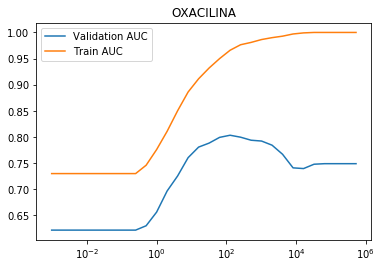

Train AUC:  0.966  and validation AUC:  0.8034


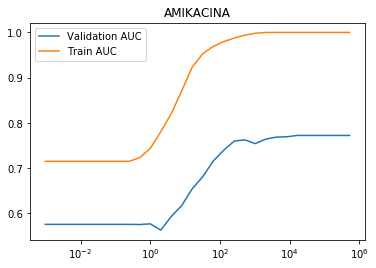

Train AUC:  1.0  and validation AUC:  0.7724


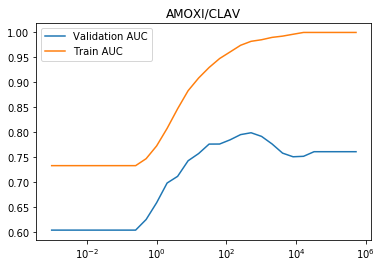

Train AUC:  0.9822  and validation AUC:  0.7994


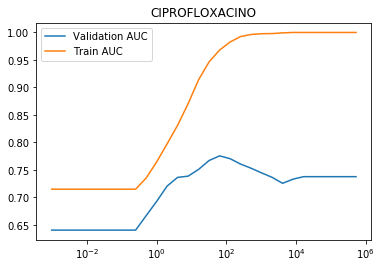

Train AUC:  0.9679  and validation AUC:  0.7756


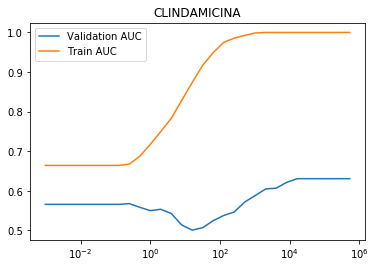

Train AUC:  1.0  and validation AUC:  0.6308


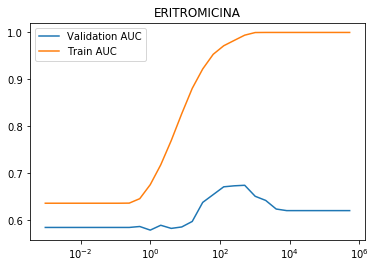

Train AUC:  0.9942  and validation AUC:  0.6747


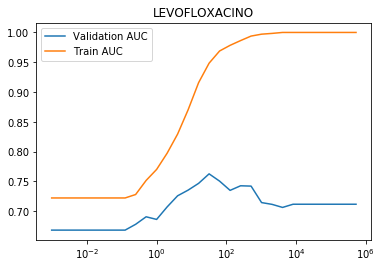

Train AUC:  0.9485  and validation AUC:  0.7628


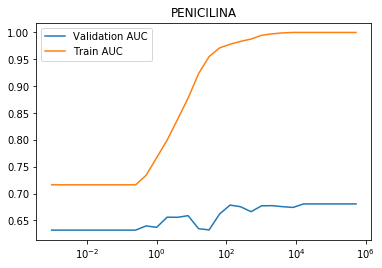

Train AUC:  1.0  and validation AUC:  0.6807


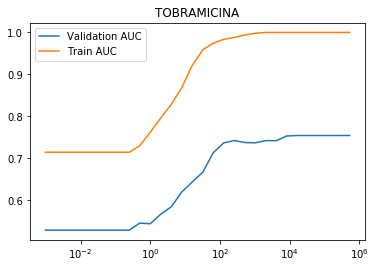

Train AUC:  1.0  and validation AUC:  0.7539


In [63]:
plot_valid_vs_train(grid_list,AUC_train,AUC_valid,'param_C')

Most of validation AUC curves (test AUC for our purposes) seem to present a low left end (meaning high overfitting, remember C is inverse of regularization strength) and a higher right end (meaning results with underfitting, not taking much into account wrong data), with a "mountain" in between, which would represent a better fitting of the data but still not overfitted.

[not very sure about which side is under or overfitting]

Overfitting occurs typically for C < 1 and underfitting for values C > 10^4. Therefore, we will use:

params = {'C':2.**np.arange(0,12)}

Now, let's try different gammas with a fixed C = 100 (around which most validation AUC peaks lie):

In [64]:
clf = SVC(kernel='rbf', class_weight='balanced', C=100)
params = {'gamma':2.**np.arange(-10,10)}
linear_SVM_best_clfs, grid_list, AUC_train, AUC_valid = try_clf(clf, params, 5, True, l1_feat_list)

['OXACILINA']
The best parameters are:  {'gamma': 0.125}
Train AUC:  0.9687  and validation AUC:  0.8054
['AMIKACINA']
Dropped  46
The best parameters are:  {'gamma': 0.25}
Train AUC:  0.9906  and validation AUC:  0.7464
['AMOXI/CLAV']
The best parameters are:  {'gamma': 0.25}
Train AUC:  0.9813  and validation AUC:  0.7966
['CIPROFLOXACINO']
The best parameters are:  {'gamma': 0.0625}
Train AUC:  0.9612  and validation AUC:  0.778
['CLINDAMICINA']
The best parameters are:  {'gamma': 8.0}
Train AUC:  1.0  and validation AUC:  0.5853
['ERITROMICINA']
The best parameters are:  {'gamma': 0.125}
Train AUC:  0.9737  and validation AUC:  0.6693
['LEVOFLOXACINO']
Dropped  2
The best parameters are:  {'gamma': 0.0625}
Train AUC:  0.9638  and validation AUC:  0.7517
['PENICILINA']
The best parameters are:  {'gamma': 0.5}
Train AUC:  0.995  and validation AUC:  0.6874
['TOBRAMICINA']
Dropped  43
The best parameters are:  {'gamma': 0.125}
Train AUC:  0.9843  and validation AUC:  0.7359


The aver

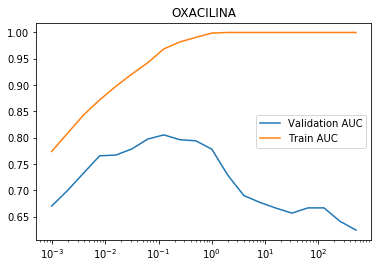

Train AUC:  0.9687  and validation AUC:  0.8054


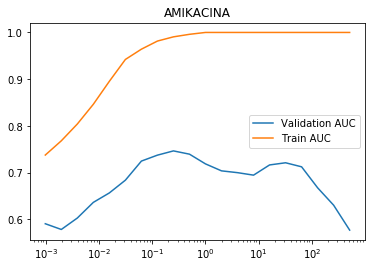

Train AUC:  0.9906  and validation AUC:  0.7464


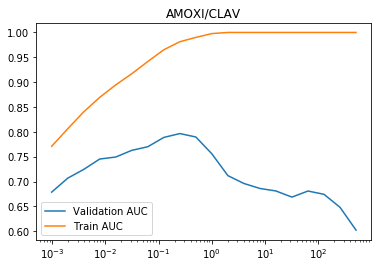

Train AUC:  0.9813  and validation AUC:  0.7966


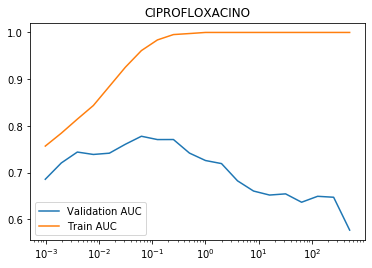

Train AUC:  0.9612  and validation AUC:  0.778


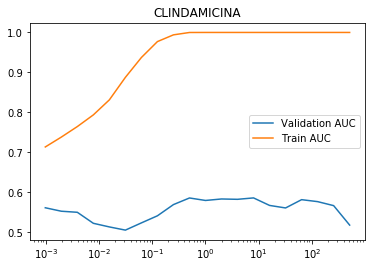

Train AUC:  1.0  and validation AUC:  0.5853


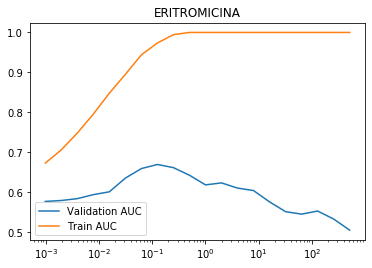

Train AUC:  0.9737  and validation AUC:  0.6693


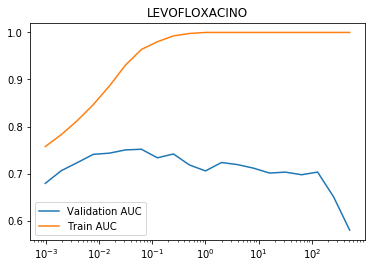

Train AUC:  0.9638  and validation AUC:  0.7517


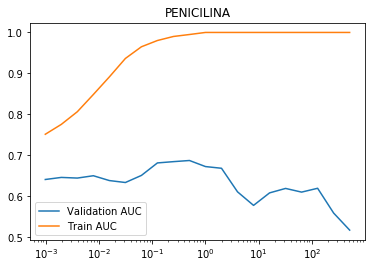

Train AUC:  0.995  and validation AUC:  0.6874


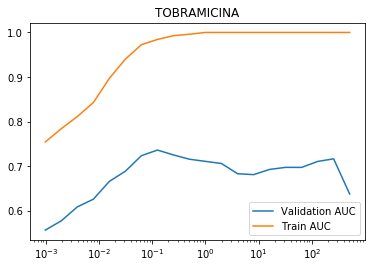

Train AUC:  0.9843  and validation AUC:  0.7359


In [68]:
plot_valid_vs_train(grid_list,AUC_train,AUC_valid,'param_gamma')

A very similar behaviour is observed here. A peak is found around gamma=0.1 in most cases. Above gamma = 1 we have overfitting (so that we shouldn't go that far) and below gamma = 0.01 it is clearly underfit. Therefore, let's use 

params = {'gamma':2.**np.arange(-8,0)}

In [97]:
# now,let's try with both parameters
clf = SVC(kernel='rbf', class_weight='balanced')
params = {'gamma':2.**np.arange(-8,0), 'C':2.**np.arange(0,12)}
linear_SVM_best_clfs, grid_list, AUC_train, AUC_valid = try_clf(clf, params, 5, True, l1_feat_list)

['OXACILINA']
The best parameters are:  {'C': 2048.0, 'gamma': 0.0078125}
Train AUC:  0.9446  and validation AUC:  0.817
['AMIKACINA']
Dropped  46
The best parameters are:  {'C': 2048.0, 'gamma': 0.03125}
Train AUC:  0.9915  and validation AUC:  0.7876
['AMOXI/CLAV']
The best parameters are:  {'C': 1024.0, 'gamma': 0.0625}
Train AUC:  0.9807  and validation AUC:  0.8046
['CIPROFLOXACINO']
The best parameters are:  {'C': 2048.0, 'gamma': 0.0078125}
Train AUC:  0.96  and validation AUC:  0.7858
['CLINDAMICINA']
The best parameters are:  {'C': 2048.0, 'gamma': 0.125}
Train AUC:  1.0  and validation AUC:  0.6036
['ERITROMICINA']
The best parameters are:  {'C': 2048.0, 'gamma': 0.0078125}
Train AUC:  0.9398  and validation AUC:  0.6922
['LEVOFLOXACINO']
Dropped  2
The best parameters are:  {'C': 1024.0, 'gamma': 0.0078125}
Train AUC:  0.9458  and validation AUC:  0.769
['PENICILINA']
The best parameters are:  {'C': 16.0, 'gamma': 0.5}
Train AUC:  0.9864  and validation AUC:  0.7017
['TOBRAM

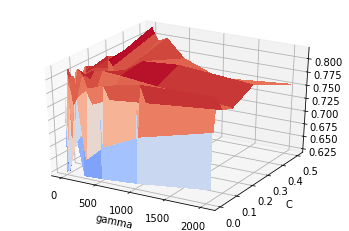

In [92]:
# plot in 2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

idx = 0

x = grid_list[idx].param_grid['C']
y = grid_list[idx].param_grid['gamma']
w0,w1 = np.meshgrid(x,y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(w0,w1,grid_list[idx].cv_results_['mean_test_score'].reshape(w0.shape),cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,label = 'Validation')
plt.ylabel('C')
plt.xlabel('gamma')
plt.show()

Ok, it is very ugly and not smooth at all.

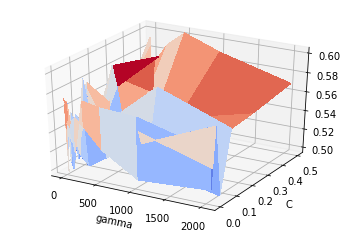

In [93]:
idx = 4

x = grid_list[idx].param_grid['C']
y = grid_list[idx].param_grid['gamma']
w0,w1 = np.meshgrid(x,y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(w0,w1,grid_list[idx].cv_results_['mean_test_score'].reshape(w0.shape),cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,label = 'Validation')
plt.ylabel('C')
plt.xlabel('gamma')
plt.show()

And for CLINDAMICINA it is damn ugly (as expected).

## With full spectrum
Now, let's see if using "all features" (that is, the full spectrum) would yield somehow better results:

In [95]:
# now,let's try with both parameters
clf = SVC(kernel='rbf', class_weight='balanced')
params = {'gamma':2.**np.arange(-8,0), 'C':2.**np.arange(0,12)}
linear_SVM_best_clfs, grid_list, AUC_train, AUC_valid = try_clf(clf, params, 5, False)

['OXACILINA']
The best parameters are:  {'C': 16.0, 'gamma': 0.25}
Train AUC:  0.9873  and validation AUC:  0.7725
['AMIKACINA']
Dropped  46
The best parameters are:  {'C': 2048.0, 'gamma': 0.0078125}
Train AUC:  0.99  and validation AUC:  0.7287
['AMOXI/CLAV']
The best parameters are:  {'C': 32.0, 'gamma': 0.125}
Train AUC:  0.9789  and validation AUC:  0.7478
['CIPROFLOXACINO']
The best parameters are:  {'C': 8.0, 'gamma': 0.25}
Train AUC:  0.9799  and validation AUC:  0.7317
['CLINDAMICINA']
The best parameters are:  {'C': 32.0, 'gamma': 0.5}
Train AUC:  1.0  and validation AUC:  0.6153
['ERITROMICINA']
The best parameters are:  {'C': 512.0, 'gamma': 0.015625}
Train AUC:  0.9701  and validation AUC:  0.6376
['LEVOFLOXACINO']
Dropped  2
The best parameters are:  {'C': 4.0, 'gamma': 0.5}
Train AUC:  0.9883  and validation AUC:  0.7435
['PENICILINA']
The best parameters are:  {'C': 4.0, 'gamma': 0.25}
Train AUC:  0.9861  and validation AUC:  0.6844
['TOBRAMICINA']
Dropped  43
The best 

As we can see, SVM RBF get's considerably worse (in all antibiotics) when not using L1 feature selection. Probably this is due to these unimportant features adding noise and false boundaries to the estimators.

### Submission

In [106]:
def get_unique_spectre(spectre, df):
  # Include the ID_sample column for the group_by
  spectre['ID_sample'] = df.ID_sample
  # MEAN OF THE SPECTRE
  spectre = spectre.groupby('ID_sample').mean().reset_index()
  return spectre

# to be applyied to each category
def apply_l1_feature_selection(spectrum_train,vect): # vect is l1_feat_list[c]
    new_spectrum = spectrum_train.copy(deep=True).iloc[:,vect]   
    return new_spectrum

def generate_csv_from_clf(clf_list, path, path_results, file_name, L1_FEATURE_SELECTION=False, feature_vector_list = None):
  # classifiers must be provided with parameters, and in a list [clf_antibiotic0, clf_antibiotic1, ...]
  # spectrum and targets full train (containing all training points) will be used for training the clfs in clf list
  # df_test must be provided as loaded from the file

  # read all data from files
  zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
  df_full_train = _pickle.loads(zf.open('TrainData.pkl').read());   zf.close()

  zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
  df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read());   zf.close()

  # Process test df to get UNIQUE samples and convert to spectrum

  # df_unique_test = df_test.drop_duplicates(subset='ID_sample')

  spectrum_test_forcsv = spectrum_in_bins(df_test,m,M,bin_size)
  spectrum_test_forcsv = get_unique_spectre(spectrum_test_forcsv, df_test)
    
  # Process train set to later train the clfs
  spectrum_full_train = spectrum_in_bins(df_full_train.iloc[:,-2:],m,M,bin_size)
  targets_full_train  = df_full_train.iloc[:,1:-2]  

  # read the submission example file
  df_submission = pd.read_csv(path+'SubmissionSample.csv') 
  categories = df_submission.columns[1:]
  df_submission['ID']= spectrum_test_forcsv['ID_sample'].values
  # To eliminate the ID_sample from the spectrum
  spectrum_test_forcsv = spectrum_test_forcsv.drop(columns=['ID_sample'])
  for c, cat in enumerate(categories): 
      # clean NaN values
      X_train, Y_train = clean_nan_samples(spectrum_full_train,targets_full_train, c, cat)

      if L1_FEATURE_SELECTION: # a boolean that decides whether to apply L1 feature selection (L1 feature list has to be already defined, and input to the function)
        X_train= apply_l1_feature_selection(X_train,feature_vector_list[c])
        X_test = apply_l1_feature_selection(spectrum_test_forcsv,feature_vector_list[c])

      else: 
        X_test = spectrum_test_forcsv.copy(deep=True
                                          
                                          )
      # fit the classifier
      clf_base = clf_list[c].fit(X_train,Y_train)
      # Compute its test prestiction and save this output
    
    
      o_test = clf_base.predict_proba(X_test)[:,1]
#       o_test = clf_base.predict_proba(X_test)
        
      df_submission[cat] = o_test

  # Save the dataframe with the predicted outputs
  df_submission = df_submission.set_index('ID')
  df_submission.to_csv(path_results + file_name + '.csv')
  print('DONE!')
  return df_submission

In [107]:
# now,let's try with both parameters
clf = SVC(kernel='rbf',probability=True)
params = {'gamma':2.**np.arange(-8,0), 'C':2.**np.arange(0,10)}
rbf_SVM_best_clfs, grid_list, AUC_train, AUC_valid = try_clf(clf, params, 5, True, l1_feat_list)

['OXACILINA']
The best parameters are:  {'C': 16.0, 'gamma': 0.5}
Train AUC:  0.9746  and validation AUC:  0.8165
['AMIKACINA']
Dropped  46
The best parameters are:  {'C': 256.0, 'gamma': 0.25}
Train AUC:  0.9935  and validation AUC:  0.7635
['AMOXI/CLAV']
The best parameters are:  {'C': 512.0, 'gamma': 0.0625}
Train AUC:  0.9687  and validation AUC:  0.8065
['CIPROFLOXACINO']
The best parameters are:  {'C': 32.0, 'gamma': 0.25}
Train AUC:  0.9805  and validation AUC:  0.7923
['CLINDAMICINA']
The best parameters are:  {'C': 512.0, 'gamma': 0.25}
Train AUC:  1.0  and validation AUC:  0.5826
['ERITROMICINA']
The best parameters are:  {'C': 512.0, 'gamma': 0.0625}
Train AUC:  0.9869  and validation AUC:  0.6896
['LEVOFLOXACINO']
Dropped  2
The best parameters are:  {'C': 512.0, 'gamma': 0.015625}
Train AUC:  0.9519  and validation AUC:  0.764
['PENICILINA']
The best parameters are:  {'C': 512.0, 'gamma': 0.125}
Train AUC:  0.9838  and validation AUC:  0.7269
['TOBRAMICINA']
Dropped  43
Th

In [108]:
name = 'RBF_L1featselection'
df_submission = generate_csv_from_clf(rbf_SVM_best_clfs,path,path_results, name, True, l1_feat_list)
print('File: '+name+' has been successfully generated')

Dropped  88
Dropped  4
Dropped  82
DONE!
File: RBF_L1featselection has been successfully generated
